In [1]:
%run ../models/checkpoint/__init__.py

In [5]:
DEVICE = torch.device('cpu')
DEVICE

device(type='cpu')

## Load data

In [8]:
%run ../datasets/__init__.py

In [9]:
dataset_kwargs = {
    'dataset_name': 'covid-x',
    'max_samples': None,
}
dataloader = prepare_data_classification(dataset_type='train', **dataset_kwargs)
dataset = dataloader.dataset
len(dataset)

Loading covid-x/train dataset...


12504

In [123]:
COVID_SAMPLES = [idx for idx, presence in dataset.get_labels_presence_for('covid') if presence]
len(COVID_SAMPLES)

421

## Load model

In [6]:
run_name = '0717_120222_covid-x_densenet-121_lr1e-06_os_aug-covid'
debug = False

In [7]:
compiled_model = load_compiled_model_classification(run_name, debug, DEVICE)
compiled_model.metadata

{'model_kwargs': {'model_name': 'densenet-121',
  'labels': ['covid', 'pneumonia', 'normal'],
  'imagenet': True,
  'freeze': False,
  'image_size': [512, 512]},
 'opt_kwargs': {'lr': 1e-06},
 'hparams': {'loss_name': 'cross-entropy',
  'loss_kwargs': {},
  'batch_size': 28},
 'dataset_kwargs': {'dataset_name': 'covid-x',
  'labels': None,
  'max_samples': None,
  'batch_size': 28,
  'image_size': [512, 512]},
 'dataset_train_kwargs': {'oversample': True,
  'oversample_label': 'covid',
  'oversample_max_ratio': None,
  'augment': True,
  'augment_label': 'covid',
  'augment_kwargs': {'crop': 0.8,
   'translate': 0.1,
   'rotation': 15,
   'contrast': 0.5,
   'brightness': 0.5},
  'undersample': False,
  'undersample_label': None}}

In [ ]:
model = compiled_model.model
_ = model.eval()

## Apply Grad-CAM

In [215]:
from torch import nn
import captum
from captum.attr import LayerGradCam, GuidedGradCam, visualization

from skimage.color import rgb2gray, gray2rgb
from skimage.transform import resize
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
%run ../utils/common.py

In [132]:
model

Densenet121CNN(
  (base_cnn): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

In [168]:
from torch.nn.functional import softmax

In [172]:
softmax(torch.tensor([[1, 2, 30],
                      [4, 5, 6.0],
                     ]), dim=-1)

tensor([[2.5437e-13, 6.9144e-13, 1.0000e+00],
        [9.0031e-02, 2.4473e-01, 6.6524e-01]])

In [174]:
class Wrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        output = self.model(x)[0]
        output = softmax(output, dim=-1)
        return output

In [175]:
wrapped_model = Wrapper(model)

In [176]:
forward_fn = lambda inputs: model(inputs)[0]
layer = model.base_cnn.features.denseblock4.denselayer16.conv2 # conv1
#layer = model.base_cnn.features.conv0

grad_cam = LayerGradCam(wrapped_model, layer)
# grad_cam = GuidedGradCam(Dummy(model), layer)

In [221]:
def plot_cam(idx, manual_norm=True, **kwargs):
    image, label = dataset[idx]
    images = image.unsqueeze(0).to(DEVICE)

    output = model(images)[0].detach().squeeze(0)
    print('Label:', label)
    print('Prediction: ', softmax(output, dim=-1))

    attributions = grad_cam.attribute(images, label) # relu_attributions=False
    attributions = attributions.detach().cpu().squeeze(0).squeeze(0)
    attributions = attributions.numpy()
    
    print('Stats: ', attributions.min(), attributions.max())
    
    if manual_norm:
        attributions = arr_to_range(attributions)
        print('Normalizing... ', attributions.min(), attributions.max())

    image_color = image.detach().permute(1, 2, 0).cpu().numpy()
    image_color = arr_to_range(image_color)

    attrs_color = gray2rgb(attributions)
    attrs_color = resize(attrs_color, image_gray.shape)

    visualization.visualize_image_attr_multiple(attrs_color,
                                                image_color,
                                                methods=['original_image',
                                                         'blended_heat_map'],
                                                signs=['all', 'all'],
                                                **kwargs,
                                               )
    
    return attrs_color

In [212]:
mpl.rcParams['figure.facecolor'] = 'white'

Label: 0
Prediction:  tensor([0.3428, 0.2902, 0.3669])
Stats:  -6.069321e-11 1.0590544e-10
Normalizing...  0.0 1.0


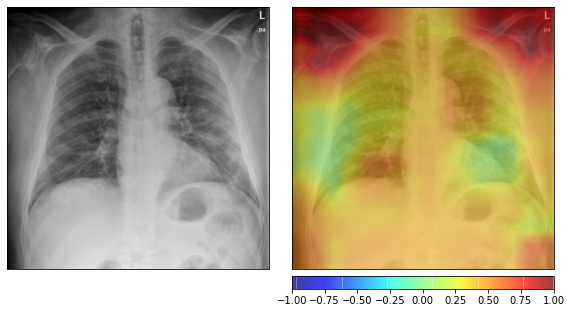

In [231]:
attrs = plot_cam(COVID_SAMPLES[30], show_colorbar=True, cmap='jet')

In [167]:
mins = []
maxs = []

for idx in tqdm(COVID_SAMPLES): # range(100) # len(dataset)
    image, label = dataset[idx]
    images = image.unsqueeze(0).to(DEVICE)

    attributions = grad_cam.attribute(images, 0)
    attributions = attributions.detach().cpu().squeeze(0).squeeze(0)
    attributions = attributions.numpy()

    mins.append(attributions.min())
    maxs.append(attributions.max())
    
np.mean(mins), np.mean(maxs)

(-2.0381943e-10, 2.047288e-10)

In [ ]:
0: (-2.0381943e-10, 2.047288e-10)
1: (-2.1670395e-10, 2.1722059e-10)
2: (-2.0727114e-10, 2.0217203e-10)